In [6]:
# Import all required toolkits
import glob
import pandas as pd
import nltk
import string
import re
import matplotlib.pyplot as plt
import seaborn as sn

In [65]:
# Read all files in a given subfolder as a labelled dataframe
def readFiles (path, label):
    reviews = [open(filename, 'r', encoding='utf-8').read() for filename in glob.glob('aclImdb/' + path + '/*.txt')]
    return pd.DataFrame({ 'label': label, 'review': reviews })

# Read train dataset
train_data = pd.concat([
    readFiles('train/pos', 'positive'),
    readFiles('train/neg', 'negative')
])
train_data.head()

,label,review
0,positive,Bromwell High is a cartoon comedy. It ran at t...
1,positive,Homelessness (or Houselessness as George Carli...
2,positive,Brilliant over-acting by Lesley Ann Warren. Be...
3,positive,This is easily the most underrated film inn th...
4,positive,This is not the typical Mel Brooks film. It wa...


In [66]:
# Read test dataset
test_data = pd.concat([
    readFiles('test/pos', 'positive'),
    readFiles('test/neg', 'negative')
])
test_data.head()

,label,review
0,positive,I went and saw this movie last night after bei...
1,positive,Actor turned director Bill Paxton follows up h...
2,positive,As a recreational golfer with some knowledge o...
3,positive,"I saw this film in a sneak preview, and it is ..."
4,positive,Bill Paxton has taken the true story of the 19...


In [67]:
# Retrieve English stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stopwords = stopwords.words('english')
# Create regex to filter html tags if any
html_regex = re.compile('<.*?>')
# Create stemmer
stemmer = nltk.PorterStemmer()
# Create lemmatizer
nltk.download('wordnet')
lemmatizer = nltk.WordNetLemmatizer()

# Perform the clean up process on an input dataset
def clean (data):
    print('Processing started')
    # 1. Remove html tags
    print('Removing tags', end='...')
    data['review_processed'] = data['review'].apply(lambda x: re.sub(html_regex, '', x))
    print('OK')
    # 2. Remove punctuation
    print('Removing punctuation', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: ''.join([char for char in x if char not in string.punctuation]))
    print('OK')
    # 3. Tokenize
    print('Tokenizing', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: re.split('\W+', x.lower()))
    print('OK')
    # 4. Remove stop words
    print('Removing stop words', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: [word for word in x if word not in stopwords])
    print('OK')
    # 5. Apply stemming or lemmatization
    print('Stemming', end='...')
    data['review_processed'] = data['review_processed'].apply(lambda x: [stemmer.stem(word) for word in x])
    #print('Lemmatization', end='...')
    #data['review_processed'] = data['review_processed'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    print('OK')
    # 6. Replace input data with processed data
    data.drop(columns=['review'], axis=1, inplace=True)
    data.rename(columns={'review_processed': 'review'}, inplace=True)
    print('Processing finished')
    
# Process train dataset
clean(train_data)
train_data.head()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\luccl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\luccl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Processing started
Removing tags...
Removing punctuation...
Tokenizing...
Removing stop words...
Stemming...
Processing finished


,label,review
0,positive,"[bromwel, high, cartoon, comedi, ran, time, pr..."
1,positive,"[homeless, houseless, georg, carlin, state, is..."
2,positive,"[brilliant, overact, lesley, ann, warren, best..."
3,positive,"[easili, underr, film, inn, brook, cannon, sur..."
4,positive,"[typic, mel, brook, film, much, less, slapstic..."


In [68]:
# Process test dataset
clean(test_data)
test_data.head()

Processing started
Removing tags...
Removing punctuation...
Tokenizing...
Removing stop words...
Stemming...
Processing finished


,label,review
0,positive,"[went, saw, movi, last, night, coax, friend, m..."
1,positive,"[actor, turn, director, bill, paxton, follow, ..."
2,positive,"[recreat, golfer, knowledg, sport, histori, pl..."
3,positive,"[saw, film, sneak, preview, delight, cinematog..."
4,positive,"[bill, paxton, taken, true, stori, 1913, us, g..."


In [69]:
# Save processed data so that we can skip previous steps and start over from next step
# when we are satisfied enough with our preprocessing
# SKIP if already saved
print('Saving test data', end='...')
test_data.to_pickle('test_data.pkl')
print('OK:', test_data.shape)
print('Saving train data', end='...')
train_data.to_pickle('train_data.pkl')
print('OK:', train_data.shape)

Saved test data: (25000, 2)
Saved train data: (25000, 2)


In [18]:
# Load processed data
# SKIP if already loaded
print('Loading test data', end='...')
test_data = pd.read_pickle('test_data.pkl')
print('OK', test_data.shape)
print('Loading train data', end='...')
train_data = pd.read_pickle('train_data.pkl')
print('OK', train_data.shape)

Loading test data...OK (25000, 2)
Loading train data...OK (25000, 2)


In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
# We can select the most important features (ie words) using term frequency-inverse document frequency method
# Vectorizer expect strings as it performs tokenization by default
# As we already have tokens we override the default analyzer
vectorizer = TfidfVectorizer(analyzer=lambda x: x, max_features=100)
train_tfidf = vectorizer.fit_transform(train_data['review'])
print(dict(zip(vectorizer.get_feature_names(), vectorizer.idf_)))
# Filter words according to feature selection in reviews if we'd like
#train_data['review'] = train_data['review'].apply(lambda x: [word for word in x if word in vectorizer.get_feature_names()])

{'act': 2.3408257650891464, 'actor': 2.6266240704690924, 'actual': 2.8474813258553553, 'also': 2.3778901135372488, 'anoth': 2.9753377651499266, 'back': 2.8602496300658053, 'bad': 2.472502456607044, 'believ': 3.053579903357204, 'best': 2.6513421157328203, 'better': 2.7088563556144005, 'cant': 3.0654997433594384, 'cast': 2.9307857117355627, 'charact': 2.121757161583228, 'come': 2.5762365778543197, 'could': 2.4533292291441904, 'didnt': 2.9764918333680335, 'director': 2.946070155455911, 'doesnt': 2.9285818540942428, 'dont': 2.3956576877807962, 'end': 2.3471136471666307, 'enjoy': 2.9738970503062854, 'even': 2.090684118218954, 'ever': 2.6751904549995027, 'everi': 3.032903345119279, 'fact': 3.0969125826095367, 'feel': 2.853589769384528, 'film': 1.5333157518036038, 'find': 2.786215090134176, 'first': 2.3919500991055473, 'funni': 3.115979563920058, 'get': 2.0271505661794205, 'girl': 3.2580342088661918, 'give': 2.677114560349933, 'go': 2.3431216258970933, 'good': 1.9677292941601767, 'great': 2.3

Counting words...OK


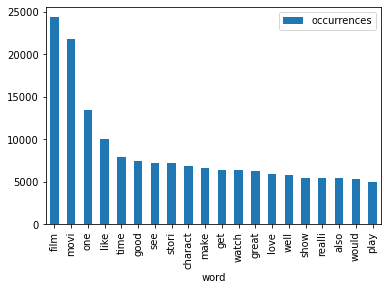

Counting words...OK


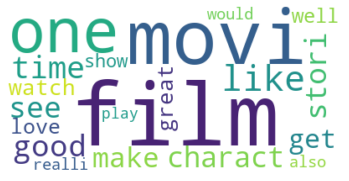

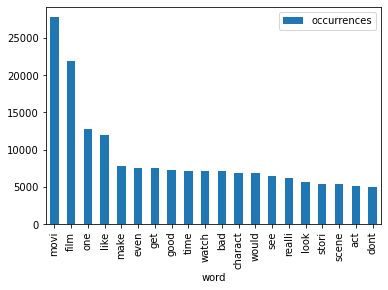

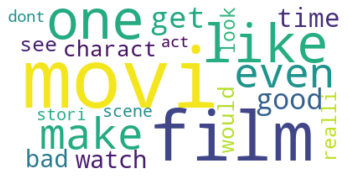

In [19]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Perform a full vectorization of labelled data
def count_words (data):
    print('Counting words', end='...')
    vectorizer = CountVectorizer(analyzer=lambda x: x)
    counts = vectorizer.fit_transform(data['review'])
    # Create a data frame to handle word occurrences
    occurrences = pd.DataFrame({'word': vectorizer.get_feature_names(), 'occurrences': counts.toarray().sum(axis=0)})
    occurrences.sort_values(by=['occurrences'], ascending=False, inplace=True)
    print('OK')
    return occurrences

# Display a distribution plot and a word cloud
def display_words (occurrences):
    occurrences.plot(x='word', y='occurrences', kind='bar')
    plt.show()
    wordcloud = WordCloud(background_color='white').fit_words(dict(occurrences.values.tolist()))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")

# Display statistics about N most used words in positive/negative reviews
positive_occurrences = count_words(train_data[train_data['label'] == 'positive'])
display_words(positive_occurrences.head(20))
negative_occurrences = count_words(train_data[train_data['label'] == 'negative'])
display_words(negative_occurrences.head(20))